In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from pca_pack import MultiModalityPCA

In [5]:
class MultiModalityPCADiagnostics:
    """
    Performs normalization, singular value analysis, and principal component diagnostics for multimodal data.

    Methods
    -------
    normalize_obs(X_list, K_list):
        Normalize the noise level for each modality after regressing out top K PCs.
    normalize_pc(U_list):
        Normalize principal components for each modality.
    plot_pc(X_list, labels, K_list, nPCs=2, to_show=False, to_save=False):
        Plots singular values and PC distributions for each modality.
    """

    def normalize_obs(self, X_list, K_list):
        """
        Normalize the noise level of each modality after regressing out top K principal components.

        Parameters
        ----------
        X_list : list of ndarray
            List of m data matrices X_k of shape (n_samples, p_k).
        K_list : list of int
            List of m values specifying the number of principal components per modality.

        Returns
        -------
        X_normalized_list : list of ndarray
            List of normalized matrices.
        """
        if len(X_list) != len(K_list):
            raise ValueError("Mismatch: Number of modalities and number of K values must be the same.")

        X_normalized_list = []
        for k, (X_k, K_k) in enumerate(zip(X_list, K_list)):
            if K_k == 0:
                raise ValueError(f"Modality {k}: # Principal Components (K) cannot be zero.")

            n_features = X_k.shape[1]
            U, Lambda, Vh = np.linalg.svd(X_k, full_matrices=False)

            # Extract top-K components
            U_K = U[:, :K_k]
            Lambda_K = Lambda[:K_k]
            V_K = Vh[:K_k, :]

            # Compute residual matrix
            R = X_k - (U_K * Lambda_K) @ V_K
            tauSq = np.sum(R**2) / n_features

            # Normalize by estimated noise level
            X_normalized = X_k / np.sqrt(tauSq)
            X_normalized_list.append(X_normalized)

            print(f"[Modality {k}] Estimated noise std deviation: {np.sqrt(tauSq):.4f}")

        return X_normalized_list

    def normalize_pc(self, U_list):
        """
        Normalize the principal components for each modality.

        Parameters
        ----------
        U_list : list of ndarray
            List of principal component matrices U_k of shape (n_samples, r_k).

        Returns
        -------
        U_normalized_list : list of ndarray
            List of normalized PC matrices.
        """
        return [U_k / np.sqrt((U_k**2).sum(axis=0)) * np.sqrt(len(U_k)) for U_k in U_list]

    def plot_pc(self, X_list, labels, K_list, nPCs=2, to_show=False, to_save=False):
        """
        Plots singular values and PC distributions for each modality.

        Parameters
        ----------
        X_list : list of ndarray
            List of m data matrices X_k of shape (n_samples, p_k).
        labels : list of str
            List of modality names for labeling plots.
        K_list : list of int
            List of values specifying the number of principal components per modality.
        nPCs : int, optional
            Number of principal components to visualize (default is 2).
        to_show : bool, optional
            Whether to display the plots (default is False).
        to_save : bool, optional
            Whether to save the plots (default is False).
        """
        for k, (X_k, label, K_k) in enumerate(zip(X_list, labels, K_list)):
            print(f"\nPlotting PCA diagnostics for {label} (Modality {k})")

            U, S, Vh = np.linalg.svd(X_k, full_matrices=False)

            # Singular value spectrum
            plt.figure(figsize=(10, 3))
            plt.scatter(range(len(S)), S)
            plt.title(f'Singular Values - {label}')
            if to_save:
                plt.savefig(f'figures/singvals_{label}.png')
            if to_show:
                plt.show()
            plt.close()

            # PC distribution analysis
            for i in range(min(nPCs, K_k)):
                fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

                ax1.hist(U[:, i], bins=50)
                scipy.stats.probplot(U[:, i], plot=ax2)
                ax1.set_title(f'Left PC {i+1}')
                ax2.set_title(f'Q-Q Left PC {i+1}')

                ax3.hist(Vh[i, :], bins=50)
                scipy.stats.probplot(Vh[i, :], plot=ax4)
                ax3.set_title(f'Right PC {i+1}')
                ax4.set_title(f'Q-Q Right PC {i+1}')

                if to_save:
                    fig.savefig(f'figures/PC_{i}_{label}.png')
                if to_show:
                    plt.show()
                plt.close()

[Modality 0] Estimated noise std deviation: 0.9182
[Modality 1] Estimated noise std deviation: 0.9416
[Modality 2] Estimated noise std deviation: 0.9158

Plotting PCA diagnostics for Modality A (Modality 0)


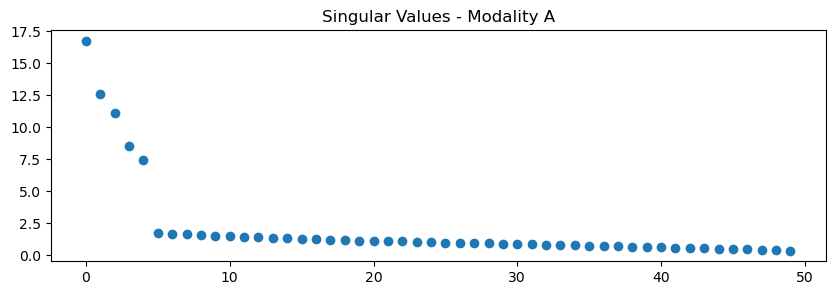

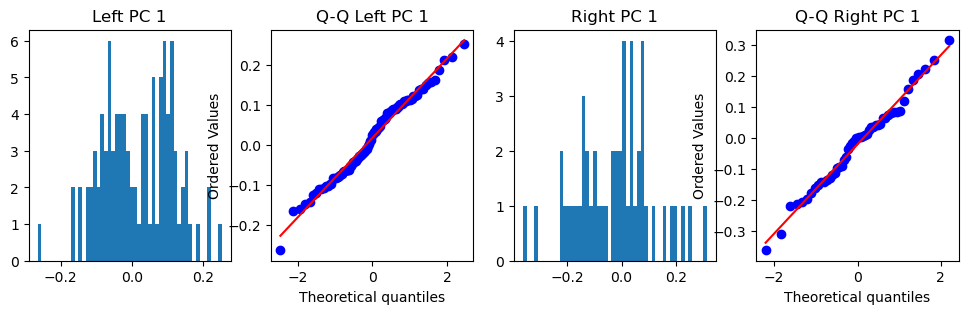

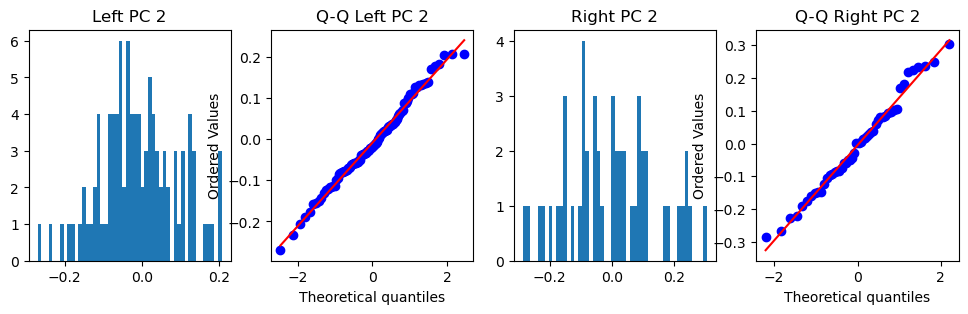


Plotting PCA diagnostics for Modality B (Modality 1)


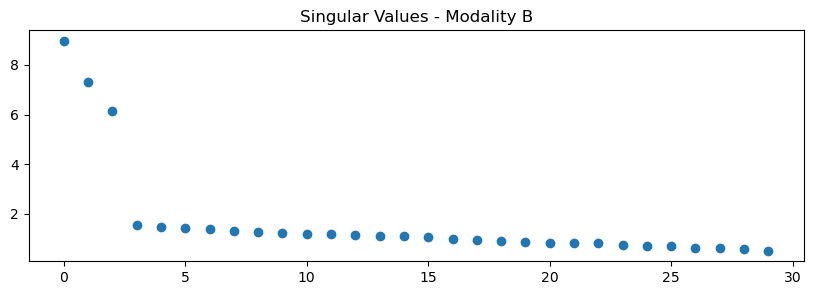

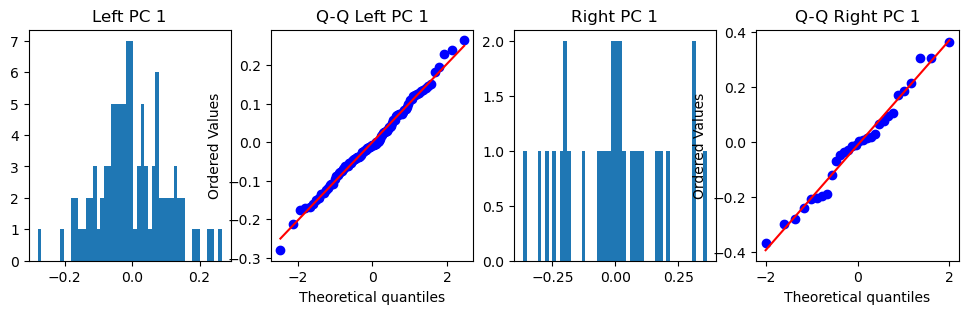

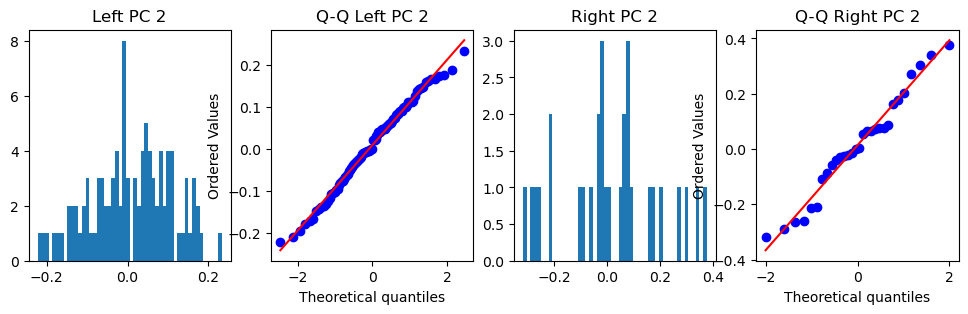


Plotting PCA diagnostics for Modality C (Modality 2)


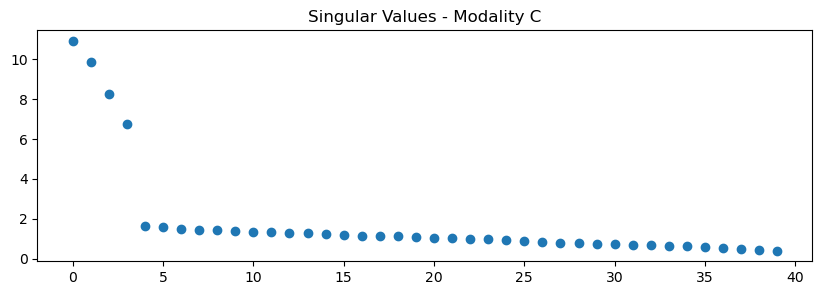

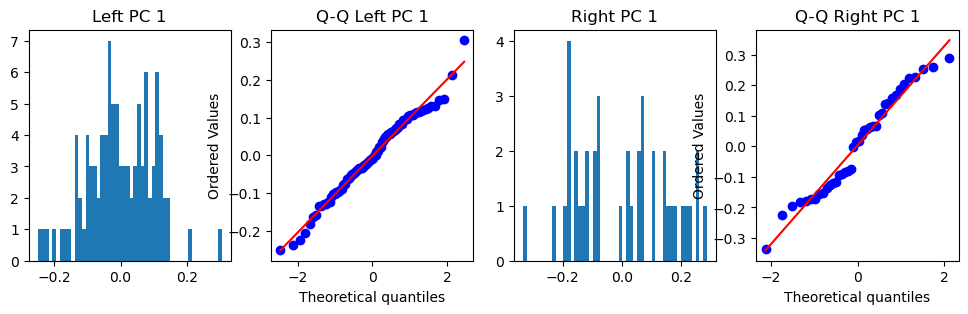

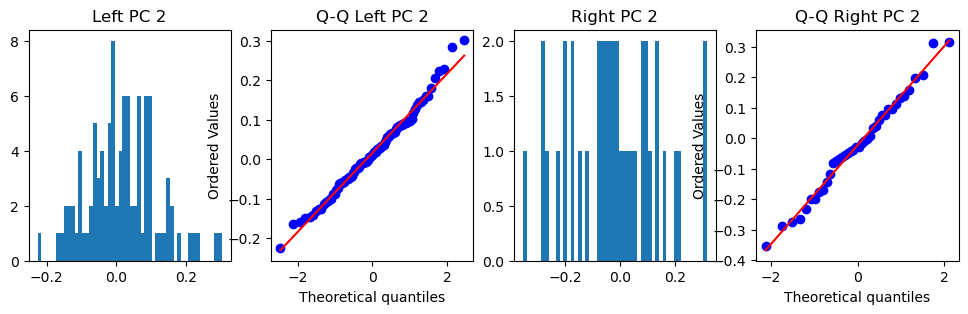

In [6]:
if __name__ == "__main__":
    pca_diag = MultiModalityPCADiagnostics()

    # Generate synthetic multimodal data
    n_samples = 100
    p_list = [50, 30, 40]  # Different feature dimensions
    K_list = [5, 3, 4]  # Number of PCs per modality
    labels = ["Modality A", "Modality B", "Modality C"]

    pca_model = MultiModalityPCA()
    X_list = pca_model.generate_synthetic_data(n_samples, p_list, K_list)

    # Normalize observations
    X_normalized_list = pca_diag.normalize_obs(X_list, K_list)

    # Perform PCA diagnostics
    pca_diag.plot_pc(X_normalized_list, labels, K_list, to_show=True, to_save=False)